In [1]:
import mteb, pickle, os, sys, json, glob
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


from mteb import MTEB
from sentence_transformers import SentenceTransformer

from llama_index.core.schema import NodeRelationship


# Embedding evaluation

## MTEB embedding model evaluation

In [ ]:
model_names = {"BAAI/bge-small-en-v1.5",
              "all-mpnet-base-v2",
                "BAAI/bge-m3",
                "all-MiniLM-L6-v2",  
                "all-MiniLM-L12-v2"}
                
tasks  = mteb.get_tasks(task_types=["Retrieval"], languages=["eng"], domains=["Medical"]) # tasks=["MedicalQARetrieval", "PublicHealthQA"]
evaluation = MTEB(tasks)

In [ ]:
for name in model_names:
    model = SentenceTransformer(name)
    evaluation = MTEB(tasks)
    results = evaluation.run(model, output_folder=f"results/{name}")


In [5]:


# Define the path to the JSON files
json_files = glob.glob("/home/lasa14/scratch-llm/results/MTEB/**/*.json", recursive=True)

# Iterate through each file and extract the "main_score"
for file in json_files:
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            main_score = data.get("scores", {}).get("test", [{}])[0].get("main_score", None)
            if main_score is not None:
                print(f"File: {file}")
                print(f"Main Score: {main_score}\n")
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {file}")

File: /home/lasa14/scratch-llm/results/MTEB/all-mpnet-base-v2/sentence-transformers__all-mpnet-base-v2/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0/MedrxivClusteringP2P.v2.json
Main Score: 0.396112

File: /home/lasa14/scratch-llm/results/MTEB/all-mpnet-base-v2/sentence-transformers__all-mpnet-base-v2/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0/ClusTREC-Covid.json
Main Score: 0.852079

File: /home/lasa14/scratch-llm/results/MTEB/all-mpnet-base-v2/sentence-transformers__all-mpnet-base-v2/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0/ArXivHierarchicalClusteringS2S.json
Main Score: 0.56301

File: /home/lasa14/scratch-llm/results/MTEB/all-mpnet-base-v2/sentence-transformers__all-mpnet-base-v2/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0/ArXivHierarchicalClusteringP2P.json
Main Score: 0.614734

File: /home/lasa14/scratch-llm/results/MTEB/all-mpnet-base-v2/sentence-transformers__all-mpnet-base-v2/12e86a3c702fc3c50205a8db88f0ec7c0b6b94a0/MedrxivClusteringS2S.v2.json
Main Score: 0.364967

File: /home/lasa14/sc

### Plot MTEB evaluation values

In [ ]:
# ...existing code...

# Prepare data for plotting
colors = ["blue", "green"]  # Assign colors for datasets
dataset_names = list(set(dataset for scores in model_scores.values() for dataset in scores.keys()))
dataset_colors = {dataset: colors[i % len(colors)] for i, dataset in enumerate(dataset_names)}

plt.figure(figsize=(12, 8))

# Track datasets added to the legend
added_to_legend = set()

for model_name, datasets in model_scores.items():
    for dataset_name, scores in datasets.items():
        plt.scatter(
            [model_name] * len(scores),
            scores,
            color=dataset_colors[dataset_name],
            label=dataset_name if dataset_name not in added_to_legend else None
        )
        added_to_legend.add(dataset_name)

# Add labels and legend
plt.xlabel("Model")
plt.ylabel("Main Score")
plt.title("Main Scores by Model and Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(title="Dataset", loc="upper left")
plt.show()

# Generate subgraph

In [6]:
#import nodes from pickle from the storage
# with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_embedded_mpnet_base_v2.pkl'), 'rb') as f:
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_all-mpnet-base-v2.pkl'), 'rb') as f:
    all_nodes_embedded = pickle.load(f)

## Find nodes that have edges of multiple types:

In [ ]:
from collections import defaultdict
from tqdm.notebook import tqdm  # Import tqdm for progress bar

# Create a dictionary to map node IDs to nodes for faster lookup
node_dict = {node.node_id: node for node in all_nodes_embedded}

# Create a dictionary to track connections between node types
node_type_connections = defaultdict(set)

# Iterate through all nodes and their relationships with a progress bar
for node in tqdm(all_nodes_embedded, desc="Processing nodes"):
    for rel in node.relationships.get(NodeRelationship.CHILD, []):
        target_node = node_dict.get(rel.node_id)  # Use dictionary lookup instead of searching the list
        if target_node:
            target_node_type = target_node.metadata.get('node_type', 'unknown')
            node_type_connections[node.node_id].add(target_node_type)

# Find all nodes connected to at least 4 different types
def find_nodes_with_four_types(node_type_connections):
    nodes_with_four_types = []
    for node_id, connected_types in node_type_connections.items():
        if len(connected_types) >= 10:
            nodes_with_four_types.append((node_id, connected_types))
    return nodes_with_four_types

nodes_with_four_types = find_nodes_with_four_types(node_type_connections)

# Store the nodes with at least 4 different types
if nodes_with_four_types:
    print(f"Found {len(nodes_with_four_types)} nodes with connections to at least 4 different types.")
    for node_id, connected_types in nodes_with_four_types:
        print(f"Node ID: {node_id}, Connected Types: {connected_types}")
else:
    print("No nodes found with connections to at least 4 different types.")

In [ ]:
node_index = next((i for i, node in enumerate(all_nodes_embedded) if node.node_id == "12120"), None)
node_index

98971

## Obtain the nodes from the subgraph

In [2]:
#small subgraph with text nodes

def generate_subgraph(all_nodes_embedded):
    """
    Generate a subgraph from the given node embeddings.
    """
    subgraph_nodes = []
    start_node = all_nodes_embedded[98971]
    related_nodes_info = start_node.relationships.get(NodeRelationship.CHILD, [])

    related_nodes = []
    edges = []
    for relation in related_nodes_info:
        # Find the related node by its node_id
        related_node = next((node for node in all_nodes_embedded if node.node_id == relation.node_id), None)
        if related_node:
            related_nodes.append(related_node)
            edges.append((start_node.node_id, related_node.node_id, relation.metadata))
    subgraph_nodes = [start_node] + related_nodes  # Include the starting node and its neighbors
    return subgraph_nodes


plot the subgraph

In [5]:

def plot_subgraph(subgraph_nodes):
    """
    Plot the node embeddings of the subgraph using t-SNE for dimensionality reduction.
    """
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)  # trial and error, 15 seems to be the cut off
    # Get the embeddings and labels
    embeddings = np.array([node.embedding for node in subgraph_nodes])

    reduced_embeddings = tsne.fit_transform(embeddings)
    labels = [node.metadata['node_type'] for node in subgraph_nodes]

    # Convert labels to numerical values for coloring
    label_to_num = {label: idx for idx, label in enumerate(set(labels))}
    numeric_labels = [label_to_num[label] for label in labels]

    # make a subplot for each element in 'embeddings'
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='tab10')

    # Add a legend on the side
    legend_labels = list(label_to_num.keys())
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Types", loc="upper left")

    # Add labels and title
    plt.title("Visualization of Node Embeddings")
    plt.show()

Loading file: all_nodes_all-MiniLM-L12-v2.pkl
Loading file: all_nodes_all-MiniLM-L6-v2.pkl
Loading file: all_nodes_all-mpnet-base-v2.pkl
Loading file: all_nodes_bge-m3.pkl
Loading file: all_nodes_bge-small-en-v1.5.pkl


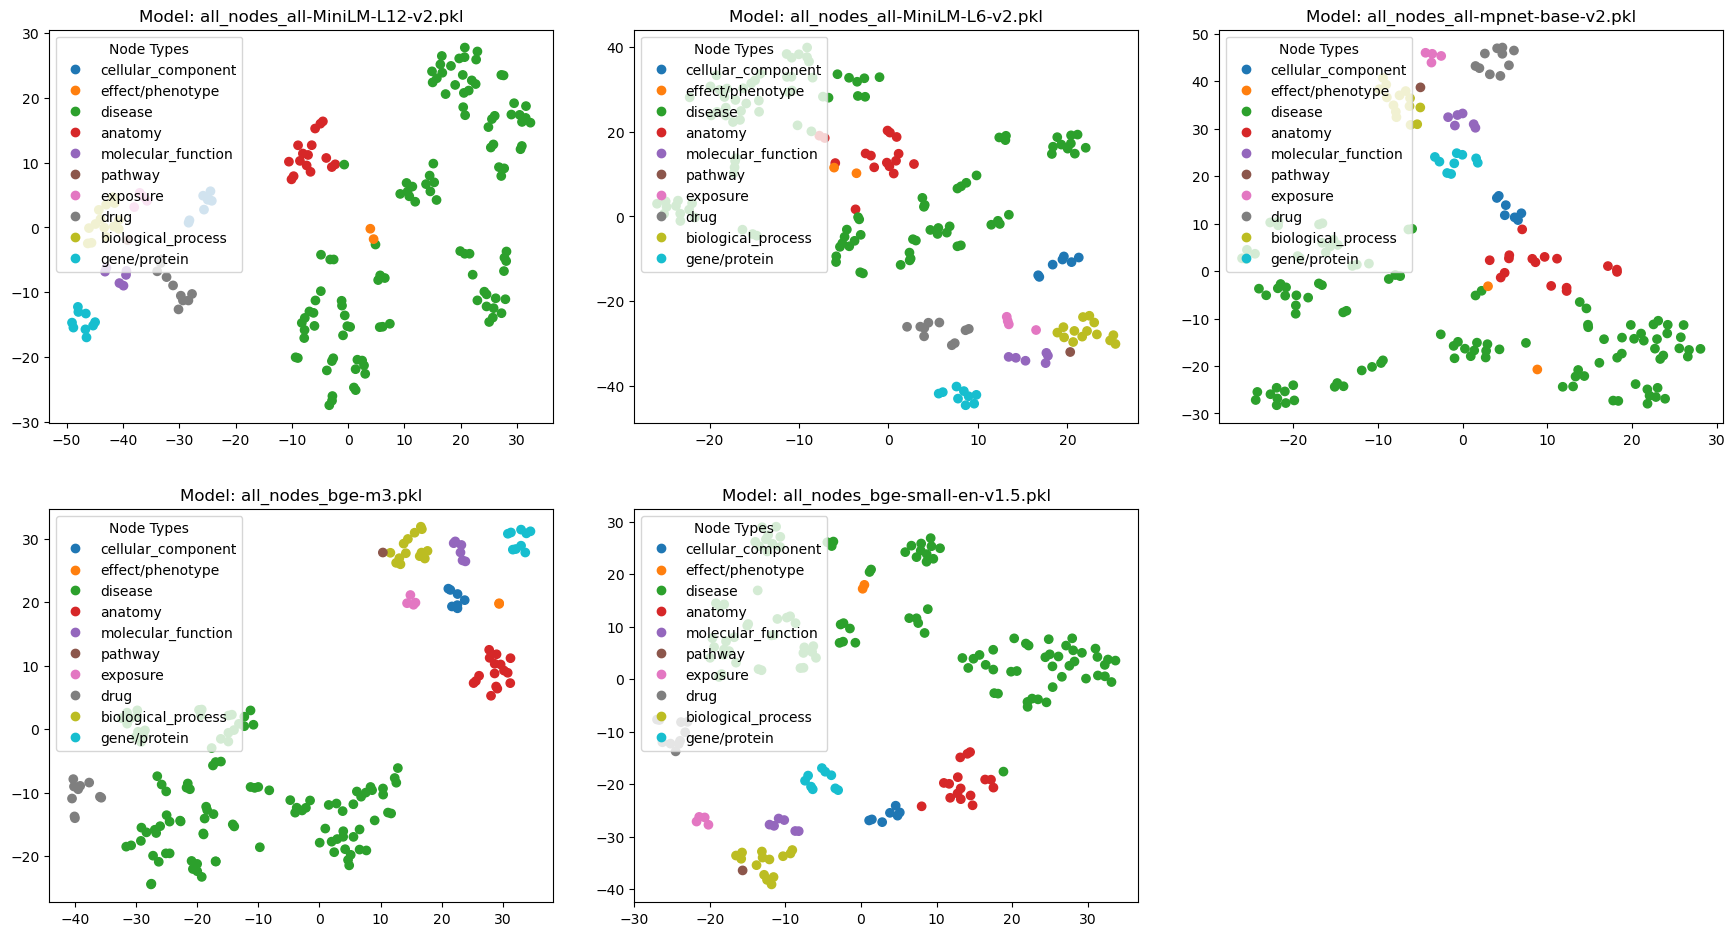

In [3]:

def plot_subgraph(subgraph_nodes, embedding_files):
    """
    Plot the node embeddings of the subgraph using t-SNE for dimensionality reduction.
    Each embedding model is visualized in a separate subplot.
    """
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Adjusted figure size for better readability
    axs = axs.flat  # Flatten the axes array for easier indexing

    for i, embedding_file in enumerate(embedding_files):
        if i >= len(axs):  # Ensure we don't exceed the number of subplots
            break
        
        print(f"Loading file: {embedding_file}")
        # Load the embeddings for the current model
        with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/{embedding_file}'), 'rb') as f:
            all_nodes_embedded = pickle.load(f)

        # Generate the subgraph
        subgraph_nodes = generate_subgraph(all_nodes_embedded)

        # Extract embeddings and labels
        embeddings = np.array([node.embedding for node in subgraph_nodes])
        labels = [node.metadata['node_type'] for node in subgraph_nodes]

        # Perform t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42, perplexity=10)
        reduced_embeddings = tsne.fit_transform(embeddings)

        # Convert labels to numerical values for coloring
        label_to_num = {label: idx for idx, label in enumerate(set(labels))}
        numeric_labels = [label_to_num[label] for label in labels]

        # Plot the embeddings in the current subplot
        scatter = axs[i].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='tab10')

        # Add a legend
        legend_labels = list(label_to_num.keys())
        axs[i].legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Types", loc="upper left")

        # Add title
        axs[i].set_title(f"Model: {embedding_file.split('/')[-1]}")

    # Remove unused subplots
    for j in range(len(embedding_files), len(axs)):
        axs[j].axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

# List of embedding files
embedding_files = [
    "all_nodes_all-MiniLM-L12-v2.pkl",
    "all_nodes_all-MiniLM-L6-v2.pkl",
    "all_nodes_all-mpnet-base-v2.pkl",
    "all_nodes_bge-m3.pkl",
    "all_nodes_bge-small-en-v1.5.pkl"
]

# Call the function to plot the subgraph
plot_subgraph(subgraph_nodes=None, embedding_files=embedding_files)

plot the diseases only from the subgraph

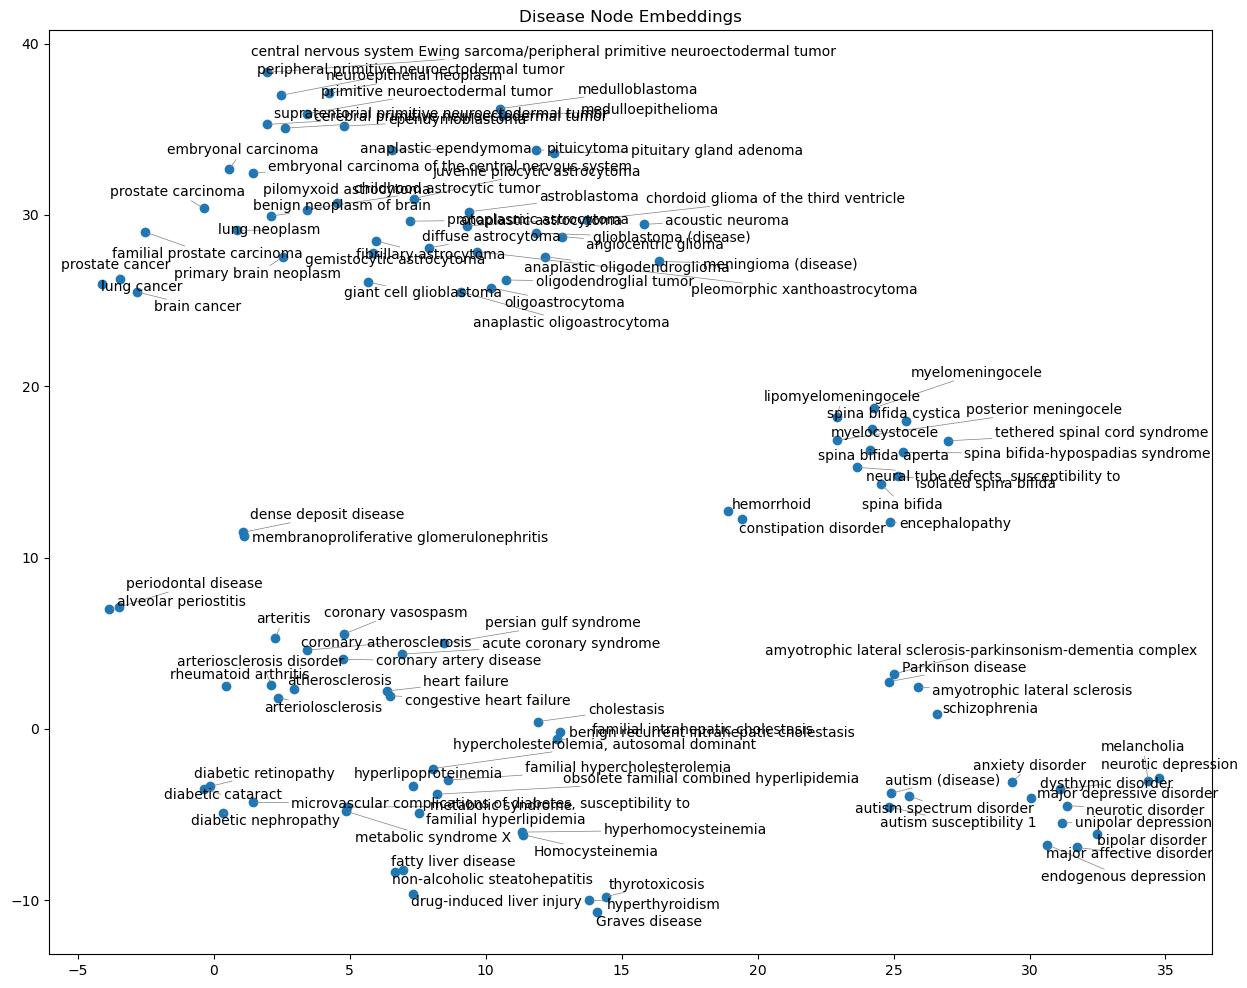

In [15]:
from adjustText import adjust_text  # label adjustment

# Plot the embeddings according to the "node_type" = 'disease' from the "reduced_embeddings" variable
disease_embeddings = []
disease_labels = []
for i, node in enumerate(subgraph_nodes):
    if node.metadata['node_type'] == 'disease':
        disease_embeddings.append(reduced_embeddings[i])
        disease_labels.append(node.metadata['node_name'])

# Plot the embeddings
disease_embeddings = np.array(disease_embeddings)
plt.figure(figsize=(15, 12))  # Increase the figure size
plt.scatter(disease_embeddings[:, 0], disease_embeddings[:, 1])

# Add labels and adjust their positions
texts = []
for i, txt in enumerate(disease_labels):
    texts.append(plt.text(disease_embeddings[i, 0], disease_embeddings[i, 1], txt))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))  # Adjust text positions

plt.title("Disease Node Embeddings")
plt.show()

## distance measures

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with a biomedical model if needed

# Compute embeddings for node names
node_embeddings = model.encode(disease_names)

similarity = cosine_similarity(node_embeddings, node_embeddings)
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_names[max_idx[0]], disease_names[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(node_embeddings, node_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = np.min(distance)
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_names[min_idx[0]], disease_names[min_idx[1]]))

In [ ]:
similarity = cosine_similarity(disease_embeddings, disease_embeddings) #direct from the dimensionality reduction
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_labels[max_idx[0]], disease_labels[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(disease_embeddings, disease_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = distance.min()
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_labels[min_idx[0]], disease_labels[min_idx[1]]))


semantic similarity:
1. genenerate embeddings from the 'node_name', these embeddings should capture relationships among the terms grouping similar closer together.
2. calculate pairwise cosine similarity/Eucleidian distance
    - (both methods agree on the most similar pair, which corresponds to the same pair in the graph)

?? should I apply dimensionality reduction

comparison of both:
-   between the distance from the 'node_name' and the distance from the index
- the distance value for the same pair should be similar: large distance for pairs distant in the index and in the 'node_name'

## Temperature plot

In [ ]:
# calculate Pearson correlations among the embeddings in index_nodes
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

index_nodes_embeddings = np.array([node.embedding for node in index_nodes])
correlations = np.corrcoef(index_nodes_embeddings)

#plot half of the correlation matrix with labels and correlation values
plt.figure(figsize=(10, 10))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes], rotation=90)
plt.yticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes])
plt.show()